

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 7 - Generative Models - Autoencoders and GANs 



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman 


<hr style="height:2pt">

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit (excluding large networks)
- Please note that the model training in this assignment can take a long time (even on a GPU). Expect to train for more than 2-3hrs per model.

<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
#PLEASE RUN THIS CELL 
import requests
import glob, cv2, os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

from skimage.io import imread
from scipy.misc import imresize
from scipy.stats import norm
from sklearn.model_selection import train_test_split


from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.layers import *
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator
import random
import utils


from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

Using TensorFlow backend.


## Question 1: Making Faces [97 pts]  </b></div>

We'll be using a subset of the Celeb A dataset to help us build facial generative models, as described on the [Celeb A](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) website. CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. 

CelebA has large diversities, large quantities, and rich annotations, including

- 10,177 number of identities,
- 202,599 number of face images, 
- 5 landmark locations, and 
- 40 binary attributes annotations per image.

### Part A:  Preparing the Data [10 pts]

**1.A.1.** Download the dataset from: [CelebA Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/celeba-dataset.zip). In the provided data you'll see the `img_align_celeba` directory. The images in that directory will form your dataset.  You may want to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).  

**1.A.2.** Load the attribute data in `list_attr_celeba.csv` into a pandas dataframe.

**1.A.3.** Pick 3 random images from the dataset, plot them, and verify that the attributes are accurate.

## Solution: Part A

In [3]:
def img_preprocess(img, output_shape, normalize=False):
    resize = output_shape
    reshape = (-1,)+resize+(3,)
    img = cv2.resize(img, resize)
    img = np.flip(img, axis=2)
    if normalize == False:
        img = img / 255.0
    elif normalize == True:
        img = img.astype(np.float32) / 127.5 - 1.0
    img = img.reshape(reshape) 
    return(img)

In [4]:
def get_rand_filenames(generator, df, n_images, img_dir, conditional):
    
    if conditional == True:
        rand_cols = np.random.choice(attr.columns, 2)
        condition = (df[rand_cols[0]]!=df[rand_cols[1]])
        df_condition = df[condition]
        subset = list(set(generator.filenames).intersection(set(df_condition['image_id'])))
        filenames = list(np.random.choice(subset,n_images))
    elif conditional == False:
        filenames = list(np.random.choice(attr['image_id'], n_images))
    
    return(filenames)    

### 1.A.2.

In [5]:
attr = pd.read_csv('data/list_attr_celeba.csv').reset_index()
attr_cols = list(set(attr.columns)^set(['image_id']))

# Sub-sample for faster training
rand_rows = np.random.choice(np.array(attr.index), 30000)
attr_train_sample = attr[attr.index.isin(rand_rows)].reset_index()
df_gen = attr
attr_train_sample.shape

(27908, 43)

### 1.A.1.

In [6]:
# # Unzip data sets
# ! unzip data/celeba-dataset.zip
# ! unzip img_align_celeba.zip

In [7]:
img_dir = 'data/img_align_celeba'

In [8]:
orig_image_shape = imread(img_dir+'/'+'000001.jpg').shape
#target_size_gen = orig_image_shape[:2]
target_size_gen = (216,176)

In [9]:
batch = 32

datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split=0.25)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_gen, directory=img_dir, 
    x_col='image_id', y_col=attr_cols,
    subset="training",
    target_size=target_size_gen,
    seed=42, shuffle=True, 
    class_mode='input', 
    batch_size=batch
    )

val_generator = datagen.flow_from_dataframe(
    dataframe=df_gen, directory=img_dir, 
    x_col='image_id', y_col=attr_cols,
    subset="validation",
    target_size=target_size_gen,
    seed=42, shuffle=True, 
    class_mode='input', 
    batch_size=batch,
    )

Found 151950 images.
Found 50649 images.


In [10]:
display(train_generator.image_shape)
display(val_generator.image_shape)

(216, 176, 3)

(216, 176, 3)

### 1.A.3.

In [11]:
rand_img = np.random.choice(attr['image_id'], 3)

         index    image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
181937  181937  181938.jpg                -1                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  ...    Sideburns  \
181937               -1    -1     -1        -1        -1  ...           -1   

        Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  \
181937       -1             -1          1                -1           -1   

        Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Young  
181937                 1                -1               -1      1  

[1 rows x 42 columns]
         index    image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
168527  168527  168528.jpg                -1               -1          -1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  ...    Sideburns  \
168527               -1    -1      1         1        -1  ...           -1   

        Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  W

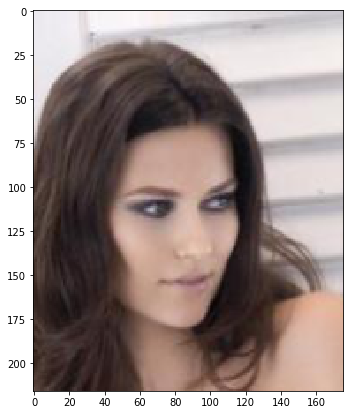

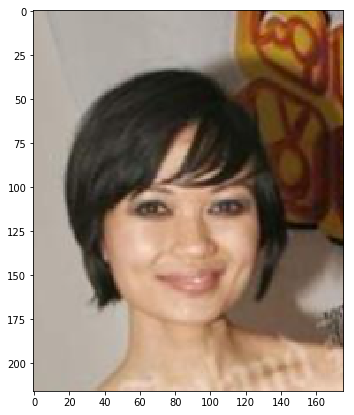

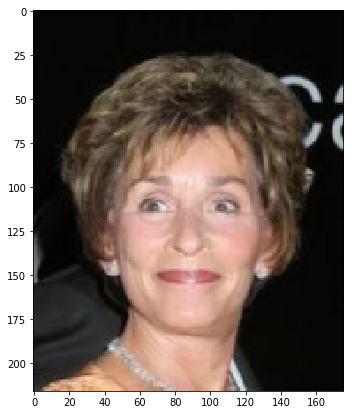

In [12]:
for i in rand_img:
    plt.figure(figsize=(20,7))
    img = imread(img_dir+'/'+i)
    img = cv2.resize(img, (176,216)) / 255.0
    plt.imshow(img, cmap='gray')
    print(attr[attr['image_id']==i])

### Part B: Building and Training a Variational Autoencoder Model [44 pts]

**1.B.1.** Create and compile a Convolutional Variational Autoencoder Model (including encoder and decoder) for the celebrity faces dataset.  Print summaries for the encoder, decoder and full autoencoder models.

**1.B.2.** Train your model on the images in the celebA dataset.

**1.B.3.** Choose a random input image.  Encode the image and then Decode the latent representation.  Plot the original image and the reconstructed output.  How do they compare?

**1.B.4.** Choose two celebrity faces from the dataset that differ according to two attributes and taking advantages of alterations of the latent representations image morph from one to the other.  See below for an example.

![](latent_1.png)

**1.B.5.** Generate and visualise around 15 celebrity faces not in your training set.  How do the generated faces compare in quality to celebrity faces from the training samples?

#### Please note that the VAE model can take a long time to train before you obtain decent results. Expect to train for more than 2-3hrs depending on the batch size

## Solution: Part B

In [13]:
# store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# load model 
def load_keras_model(model_name, custom_objs: dict):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json, custom_objects=custom_objs)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

In [14]:
def add_encoder_block(inp, filters, filter_size, model):
    if model == 'dcgan':
        x = Conv2D(filters, filter_size, padding='same')(inp)
        x = BatchNormalization()(x)
        x = Conv2D(filters, filter_size, padding='same', strides=2)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.3)(x)
    elif model == 'vae': 
        x = Conv2D(filters, filter_size, padding='same', activation='relu')(inp)
        x = BatchNormalization(axis=2)(x)
        x = Conv2D(filters, filter_size, padding='same', activation='relu')(x)
        x = MaxPool2D()(x)
    return x

def add_decoder_block(inp, filters, filter_size, model):
    if model == 'dcgan':
        x = Conv2DTranspose(filters, filter_size, padding='same', strides=2)(inp)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.3)(x)
    elif model == 'vae': 
        x = UpSampling2D()(inp)
        x = Conv2DTranspose(filters, filter_size, padding='same', activation='relu')(x)
        x = BatchNormalization(axis=2)(x)
        x = Conv2DTranspose(filters, filter_size, padding='same', activation='relu')(x)
    return x

In [15]:
def build_vae(image_shape, latent_dim, n_filters):
   
    ##### ENCODER MODEL #####
    
    input_layer = Input(shape=image_shape)

    x = add_encoder_block(input_layer, n_filters * 4, 3, model='vae')
    x = add_encoder_block(x, n_filters * 2, 3, model='vae')
    x = add_encoder_block(x, n_filters, 3, model='vae')

    # shape of the network for decoder
    shape_before_flattening = K.int_shape(x)

    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)

    # Z - Mu and Sigma
    z_mu = Dense(latent_dim)(x)
    z_log_sigma = Dense(latent_dim)(x)
    
    # Sampling
    def sampling(args):
        z_mu, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
        return(z_mu + K.exp(z_log_sigma) * epsilon)

    # sample vector from the latent distribution
    z = Lambda(sampling)([z_mu, z_log_sigma])
    
    # instantiate encoder model
    encoder = Model(input_layer, [z_mu, z_log_sigma, z], name='encoder')
    encoder.summary()
    
    ##### DECODER MODEL #####
    
    # decoder takes the latent distribution sample as input
    decoder_input = Input(K.int_shape(z)[1:])

    x = Dense(np.prod(shape_before_flattening[1:]),
                     activation='relu')(decoder_input)

    # reshape
    x = Reshape(shape_before_flattening[1:])(x)

   # use Conv2DTranspose to reverse the conv layers from the encoder
    x = add_decoder_block(x, n_filters * 4, 3, model='vae')
    x = add_decoder_block(x, n_filters * 2, 3, model='vae')
    x = add_decoder_block(x, n_filters, 3, model='vae')
    x = Conv2D(3, 3, padding='same', activation='sigmoid')(x)
    
    # instantiate decoder model
    decoder = Model(decoder_input, x)
    decoder.summary()
    
    
    def vae_loss(input_layer, output_layer):
        inputs = K.flatten(input_layer)
        outputs = K.flatten(output_layer)
        # Reconstruction loss
        xent_loss = mse(inputs, outputs)
        xent_loss = K.mean(xent_loss)
        # KL divergence
        kl_loss = -0.0001 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    # instantiate VAE model
    output_layer = decoder(encoder(input_layer)[2])
    vae = Model(input_layer, output_layer)
    vae.compile(optimizer='rmsprop', loss=vae_loss)
    vae.summary()
    
    
    return(vae, encoder, decoder)

### 1.B.1.

In [16]:
image_shape = train_generator.image_shape
latent_dim = 2
n_filters = 8

In [17]:
vae, encoder, decoder = build_vae(image_shape=image_shape, latent_dim=latent_dim, n_filters=n_filters)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 216, 176, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 216, 176, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 216, 176, 32) 704         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 216, 176, 32) 9248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

### 1.B.2.

In [18]:
step_train = int(train_generator.n//train_generator.batch_size)
step_val = int(val_generator.n//val_generator.batch_size)

history = vae.fit_generator(generator=train_generator,
                            steps_per_epoch=step_train,
                            validation_data=val_generator,
                            validation_steps=step_val,
                            epochs=7)

Epoch 1/7
4748/4748 [==============================] - 2633s 555ms/step - loss: 0.0747 - val_loss: 0.0491
Epoch 2/7
4748/4748 [==============================] - 2633s 555ms/step - loss: 0.0479 - val_loss: 0.0478
Epoch 3/7
4748/4748 [==============================] - 2631s 554ms/step - loss: 0.0474 - val_loss: 0.0468
Epoch 4/7
4748/4748 [==============================] - 2631s 554ms/step - loss: 0.0465 - val_loss: 0.0461
Epoch 5/7
4748/4748 [==============================] - 2631s 554ms/step - loss: 0.0462 - val_loss: 0.0465
Epoch 6/7
4748/4748 [==============================] - 2632s 554ms/step - loss: 0.0459 - val_loss: 0.0462
Epoch 7/7
4748/4748 [==============================] - 2633s 555ms/step - loss: 0.0456 - val_loss: 0.0458


In [19]:
store_keras_model(vae, 'model_vae')

Saved model to disk


In [20]:
custom_objs = {'latent_dim': latent_dim}
vae = load_keras_model('model_vae',custom_objs=custom_objs)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 216, 176, 3)       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 96180     
_________________________________________________________________
model_1 (Model)              (None, 216, 176, 3)       35979     
Total params: 132,159
Trainable params: 130,927
Non-trainable params: 1,232
_________________________________________________________________


### 1.B.3.

In [21]:
encoder = vae.layers[1]
decoder = vae.layers[2]

In [22]:
n_images = 5
model = vae
generator = val_generator

def gen_pred_images(model, generator, n_images):
    rand_img = np.random.choice(generator.filenames, n_images)

    fig, ax = plt.subplots(n_images,2, figsize=(15,45))

    for i in range(n_images):
        img = imread(img_dir+'/'+rand_img[i])

        ax[i,0].imshow(img, cmap='gray')


        # resize to pass to vae
        img = img_preprocess(img, generator.image_shape[:2])

        # predict using vae
        pred = vae.predict(img)


        ax[i,1].imshow(pred[0])

    return(fig,ax)



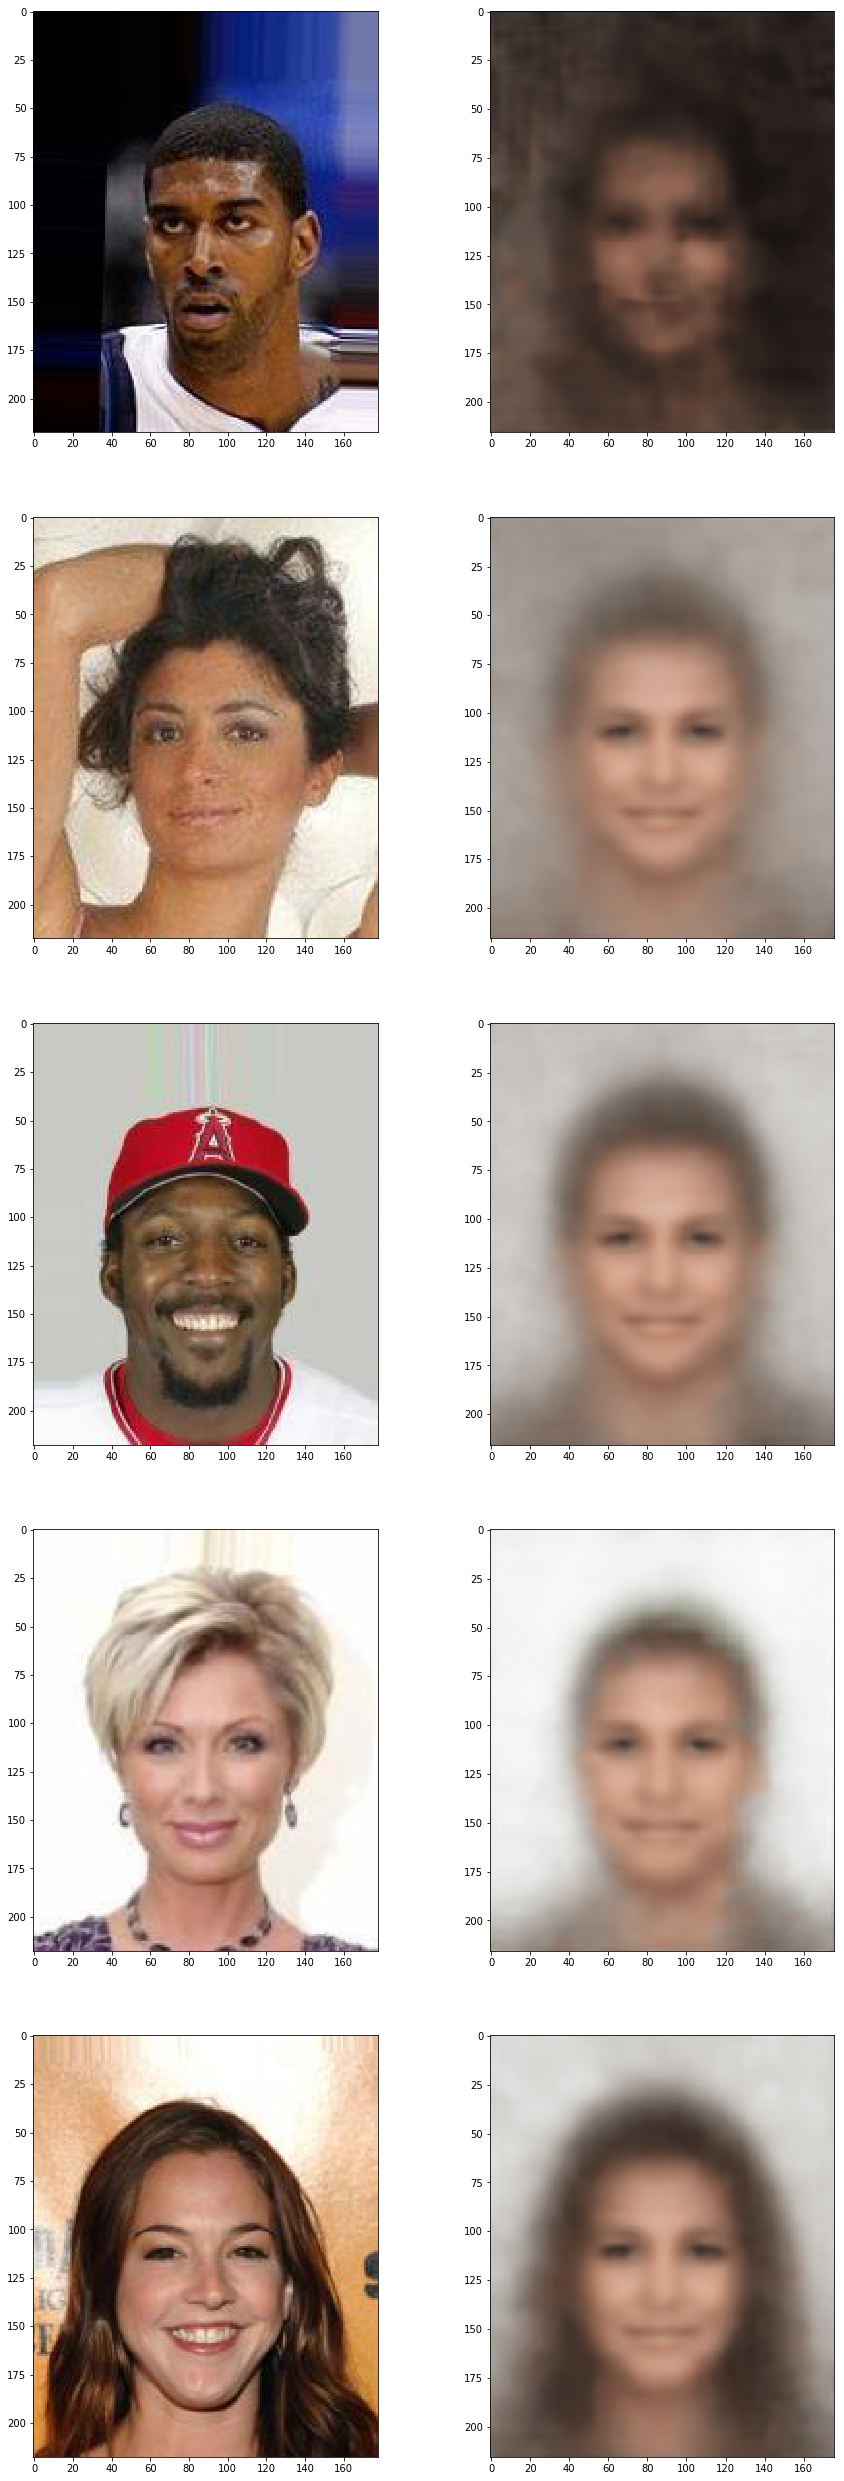

In [23]:
fig, ax = gen_pred_images(model=vae, generator=val_generator, n_images=n_images)

### 1.B.4.

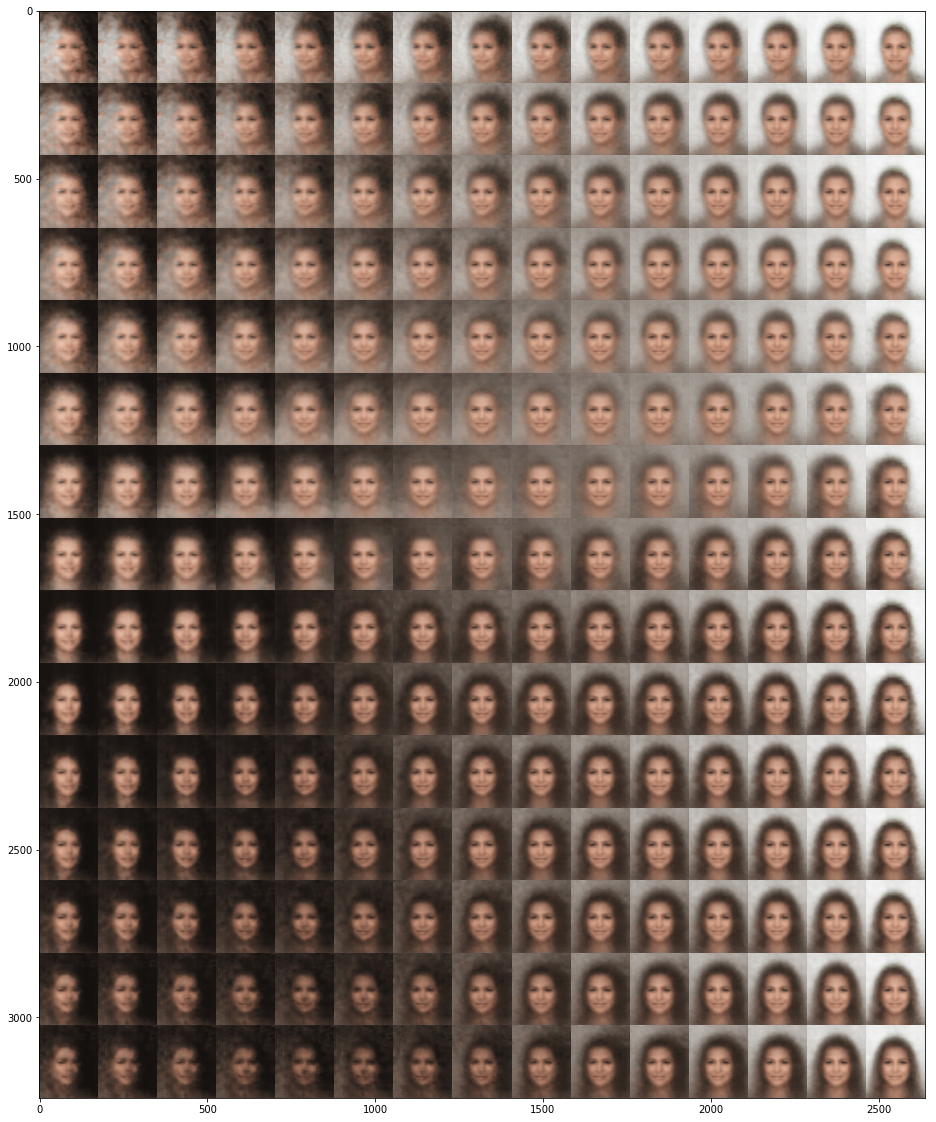

In [24]:
# Display a 2D manifold of the samples

n = 15  # figure with 20x20 samples
height = train_generator.image_shape[0]
width = train_generator.image_shape[1]

figure = np.zeros((height * n, width * n, 3))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = pred_enc[0].copy()
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(x=z_sample)
        sample = x_decoded[0]
        figure[i * height: (i + 1) * height,j * width: (j + 1) * width] = sample

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()  

### 1.B.5.

In [25]:
def generate_images(n_images, encoder, decoder):
    
    j=0
    i=0

    fig, ax = plt.subplots(3, 5, figsize=(25,15))

    for k in range(n_images):

        z_sample = np.random.random(2).reshape((1,2))
        x_decoded = decoder.predict(x=z_sample)
        sample = x_decoded[0]
        ax[i,j].imshow(sample)

        if k in [4,9]: 
            i=i+1
            j=0
        else: j=j+1
        k=k+1

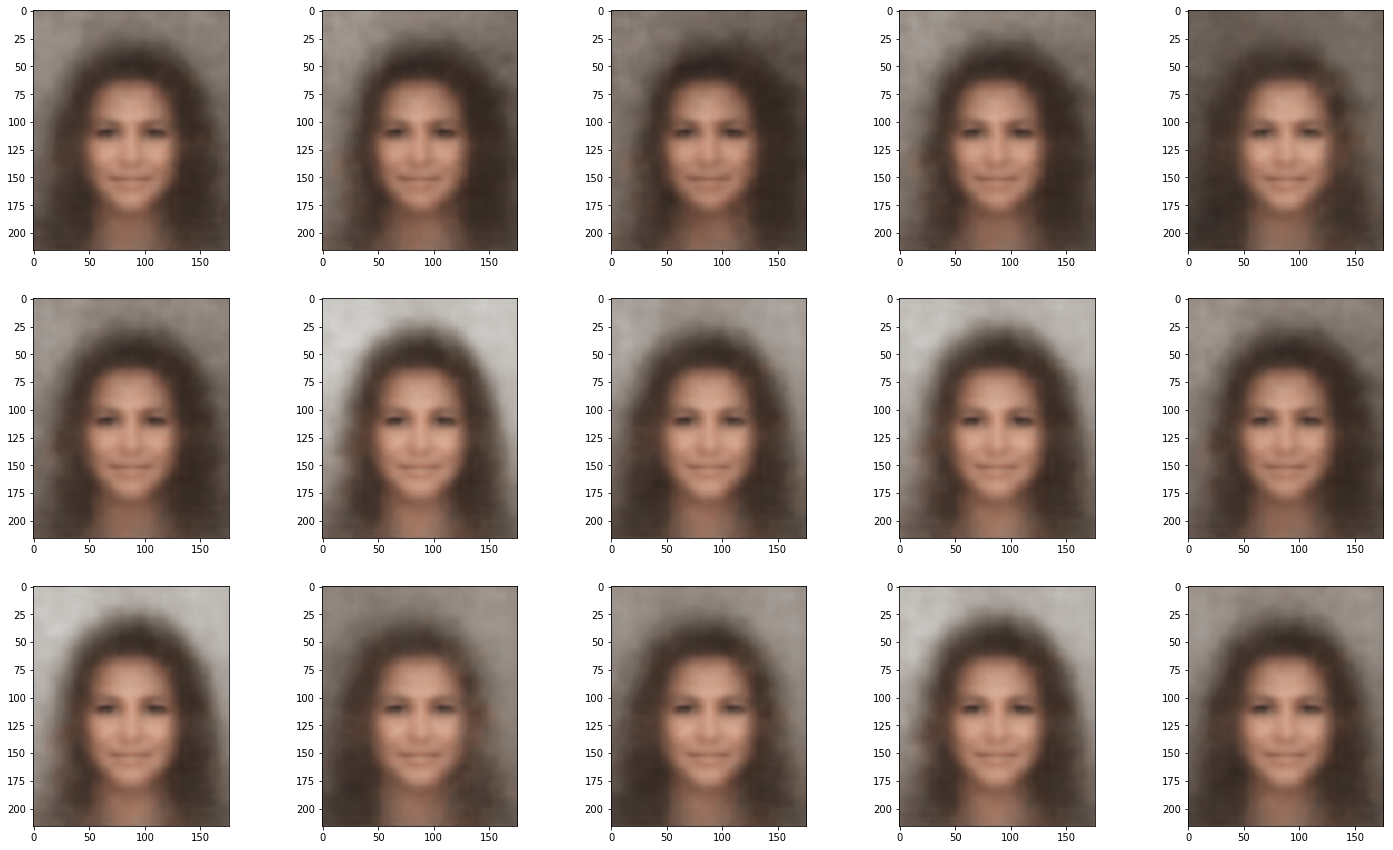

In [26]:
generate_images(n_images=15, encoder=encoder, decoder=decoder)

### Part C: Building and Training a DCGAN Model [43 pts]

**1.C.1.** Create and compile a DCGAN model for the celebrity faces dataset.  Print summaries for the discriminator and generator models.

**1.C.2.** Train your model on the images in the celeba dataset.

**1.C.3.** Generate and visualise around 15 celebrity faces.  How do the generated faces compare in quality to celebrity faces from the training samples? How do they compare in quality to the faces generated via VAE?

#### Please note that the DCGAN model can take a long time to train before you obtain good results. Expect to train for more than 2 hrs depending on the batch size and number of epochs

## Solution: Part C

In [232]:
SPATIAL_DIM = 32 # Spatial dimensions of the images.
LATENT_DIM = 100 # Dimensionality of the noise vector.
BATCH_SIZE = 128 # Batchsize to use for training.
EPOCHS = 500
DISC_UPDATES = 1  # Number of discriminator updates per training iteration.
GEN_UPDATES = 1 # Nmber of generator updates per training iteration.

FILTER_SIZE = 3 # Filter size to be applied throughout all convolutional layers.
NUM_LOAD = 10000 # Number of images to load from CelebA. Fit also according to the available memory on your machine.

In [233]:
def plot_image(x):
    plt.imshow(x * 0.5 + 0.5)

In [234]:
faces = glob.glob('data/img_align_celeba/*.jpg')
faces[0]

'data/img_align_celeba/116549.jpg'

In [235]:
X = []
# Reference to CelebA dataset here.
faces = glob.glob('data/img_align_celeba/*.jpg')

for i, f in enumerate(faces):
    img = cv2.imread(f)
    img = img_preprocess(img, (SPATIAL_DIM,SPATIAL_DIM), normalize=True)
    X.append(img[0])
    if i >= NUM_LOAD - 1:
        break
X_train = np.array(X)

(10000, 32, 32, 3)

((10000, 32, 32, 3), -1.0, 1.0)

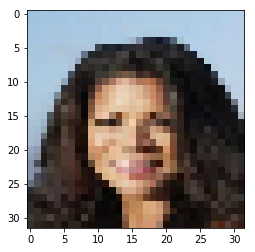

In [236]:
display(X_train.shape)
plot_image(X_train[4])
X_train.shape, X_train.min(), X_train.max()

### 1.C.1.

In [252]:
def build_dcgan(start_filters, spatial_dim, latent_dim):
    
    ### DISCRIMINATOR ###
    
    inp = Input(shape=(spatial_dim, spatial_dim, 3))
    
    d = add_encoder_block(inp, start_filters * 2, 3, model='dcgan')
    d = add_encoder_block(d, start_filters * 4, 3, model='dcgan')
    d = add_encoder_block(d, start_filters * 8, 3, model='dcgan')
    
    d = GlobalAveragePooling2D()(d)
    d = Dense(1, activation='tanh')(d)

    discriminator = Model(inputs=inp, outputs=d)
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002), 
                          metrics=['mae'])

    ### GENERATOR ###
    
    inp = Input(shape=(latent_dim,))
    
    # Projection.
    g = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(inp)
    g = BatchNormalization()(g)
    g = Reshape(target_shape=(4, 4, start_filters * 8))(g)
    
    # Decoding blocks upsample the image.
    g = add_decoder_block(g, start_filters * 8, 3, model='dcgan')
    g = add_decoder_block(g, start_filters * 4, 3, model='dcgan')
    g = add_decoder_block(g, start_filters * 2, 3, model='dcgan')
#     g = add_decoder_block(g, start_filters, 3, model='dcgan')
    
    g = Conv2D(3, kernel_size=3, padding='same', activation='tanh')(g)

    generator = Model(inputs=inp, outputs=g)

    ### FULL DCGAN ###
    
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False # Fix the discriminator part in the full setup.
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002), metrics=['mae'])

    # Print model summaries
    generator.summary()
    discriminator.summary()
    gan.summary()
        
        
    return(generator, discriminator, gan)

In [291]:
def run_training(X_train, batch_size, num_epochs, latent_dim):
    
    avg_loss_discriminator = []
    avg_loss_generator = []
    
    for epoch in range(num_epochs):

        loss_discriminator = []
        loss_generator = []
        
        steps_per_epoch = int(X_train.shape[0]//batch_size)

        for steps in range(steps_per_epoch):
        
            # Noise is generated from a uniform distribution
            noise = np.random.rand(batch_size,latent_dim)
            true_batch = X_train[np.random.choice(X_train.shape[0], batch_size, replace=False), :]

            generated_values = generator.predict(noise)
            X = np.concatenate([generated_values,true_batch])

            y_dis = np.zeros(2*batch_size)

            # Set the first half of the y values i.e. labels of the generated values to 0.9 (see 'Label smoothin below why 0.9)
            y_dis[:batch_size] = 1

            discriminator.trainable = True
            # Train discriminator using train_on_batch  
            disc_history = discriminator.train_on_batch(X, y_dis)
            discriminator.trainable = False
            
            loss_discriminator.append(disc_history[1])

            # Train generator
            # Noise is generated from a uniform distribution
            noise = np.random.rand(batch_size,latent_dim)
            y_gen = np.zeros(batch_size)    
            gan_history = gan.train_on_batch(noise, y_gen)
            
            loss_generator.append(gan_history[1])
    
        print('EPOCH: %s'%epoch)
        plt.plot(loss_discriminator, label='discriminator loss')
        plt.plot(loss_generator, label='generator loss')
        plt.ylim((0,1))
        plt.legend()
        plt.show()

In [292]:
generator, discriminator, gan = build_dcgan(start_filters=8, spatial_dim=SPATIAL_DIM, latent_dim=LATENT_DIM)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_432 (Bat (None, 1024)              4096      
_________________________________________________________________
reshape_43 (Reshape)         (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_139 (Conv2D (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_433 (Bat (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_259 (LeakyReLU)  (None, 8, 8, 64)          0         
__________

### 1.C.2.

EPOCH: 0


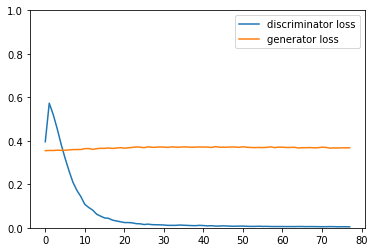

EPOCH: 1


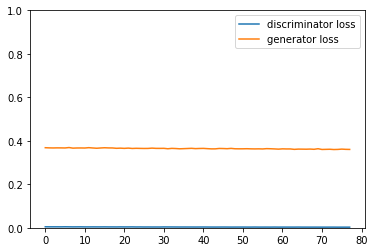

EPOCH: 2


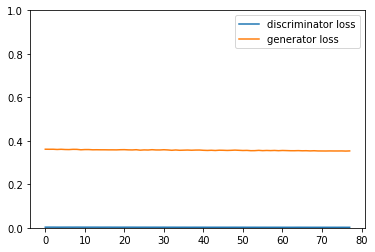

EPOCH: 3


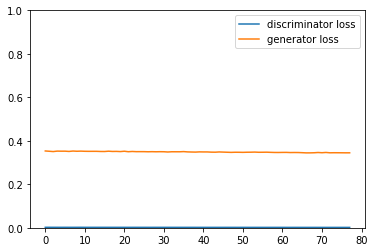

KeyboardInterrupt: 

In [293]:
run_training(X_train, batch_size=BATCH_SIZE, num_epochs=100, latent_dim=LATENT_DIM)

### 1.C.3.

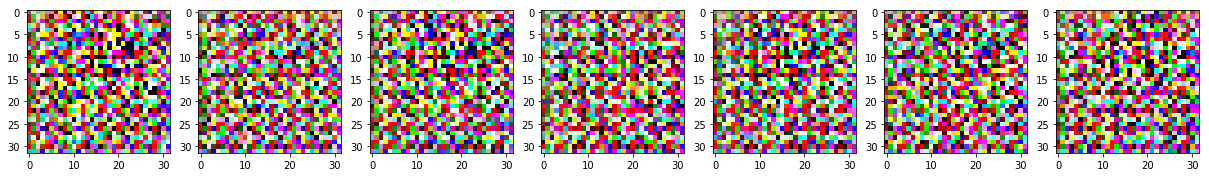

In [251]:
NUM_SAMPLES = 7
plt.figure(figsize=(NUM_SAMPLES * 3, 3))

for i in range(NUM_SAMPLES):
    noise = np.random.randn(1, LATENT_DIM) 
    pred_raw = generator.predict(noise)[0]
    pred = pred_raw * 0.5 + 0.5
    plt.subplot(1, NUM_SAMPLES, i + 1)
    plt.imshow(pred)
plt.show()

## Question 2: VAE-GANIME [3 pts - ALMOST OPTIONAL] 

Wikipedia describes [Anime]() as follows:

Anime is hand-drawn and computer animation originating from or associated with Japan.  

The word anime is the Japanese term for animation, which means all forms of animated media. Outside Japan, anime refers specifically to animation from Japan or as a Japanese-disseminated animation style often characterized by colorful graphics, vibrant characters and fantastical themes. The culturally abstract approach to the word's meaning may open up the possibility of anime produced in countries other than Japan For simplicity, many Westerners strictly view anime as a Japanese animation product. Some scholars suggest defining anime as specifically or quintessentially Japanese may be related to a new form of Orientalism

We've provided you a dataset of anime faces and we want you to create a model to generate faces in the same style using a special form of GAN, a VAE-GAN.  The term VAE-GAN was first used by Larsen et. al in their paper [“Autoencoding beyond pixels using a learned similarity metric”](https://arxiv.org/abs/1512.09300).  VAE-GAN models differentiate themselves from GANs in that their generators are variation autoencoders.

![](https://cdn-images-1.medium.com/max/800/0*KEmfTtghsCDu6UTb.png)

### Part A: Preparing the Data 

**2.A.1.** Download the dataset from [Anime-Face Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip). It contains over 20K anime faces in the form of 64x64 images.  Use them to create your anime face dataset.  Again, you may find it to your advantage to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).

### Part B: Building and Training a DCGAN 

**2.B.1.** Create and compile a DCGAN model for the anime faces dataset.  Print summaries for the generator and discriminator models

**2.B.2.** Train your model on the images in the anime faces dataset.

**2.B.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples?

### Part C: Building and Training a VAE-GAN 

**2.C.1.** Create and compile a VAE-GAN model for the anime faces dataset.  Print summaries for the encoder, decoder and discriminator models

**2.C.2.** Train your model on the images in the anime faces dataset.

**2.C.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples? How do they compare to the faces from the traditional GAN?

#### Please note that the DCGAN model can take a long time to train before you obtain good results. Expect to train for more than 2 hrs depending on the batch size and number of epochs